# Mean Force Integration

Import HILLS and COLVAR files, compute the mean force and integrate using the pyMFI (would be) module. 

Total no. of Gaussians analysed: 5000


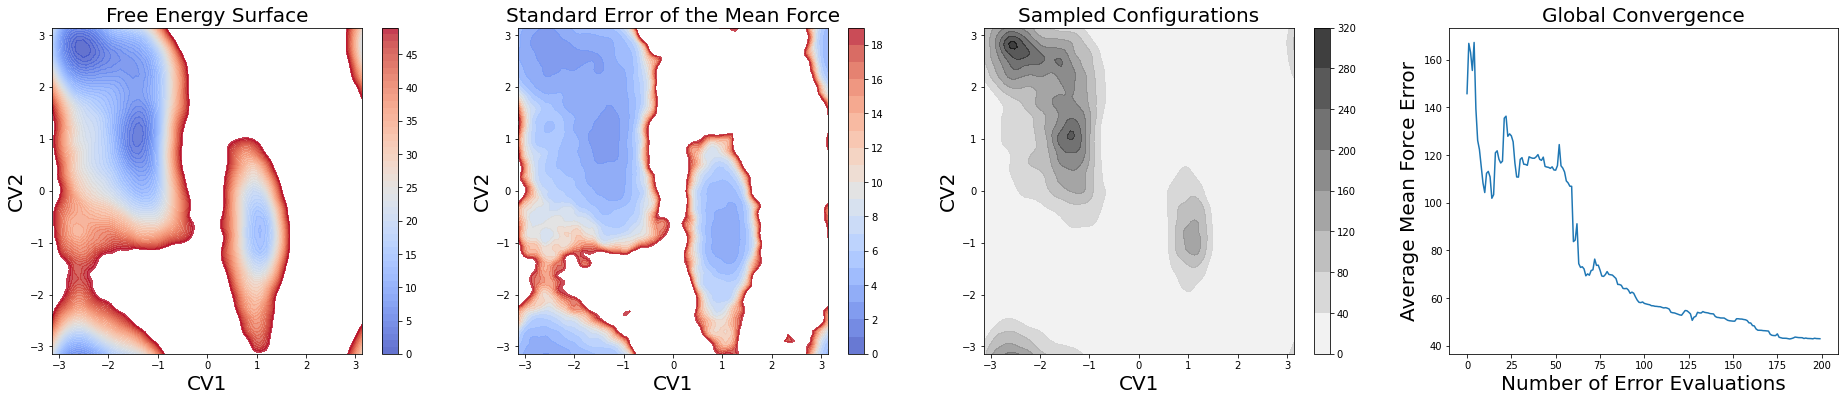

In [2]:
import numpy as np
from pyMFI import MFI

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, log_pace = 10, error_pace = 200, WellTempered=1, nhills=5000, periodic=1)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_x, Ftot_y, Ftot_den, ofe_map, ofe_history)

Total no. of Gaussians analysed: 5000


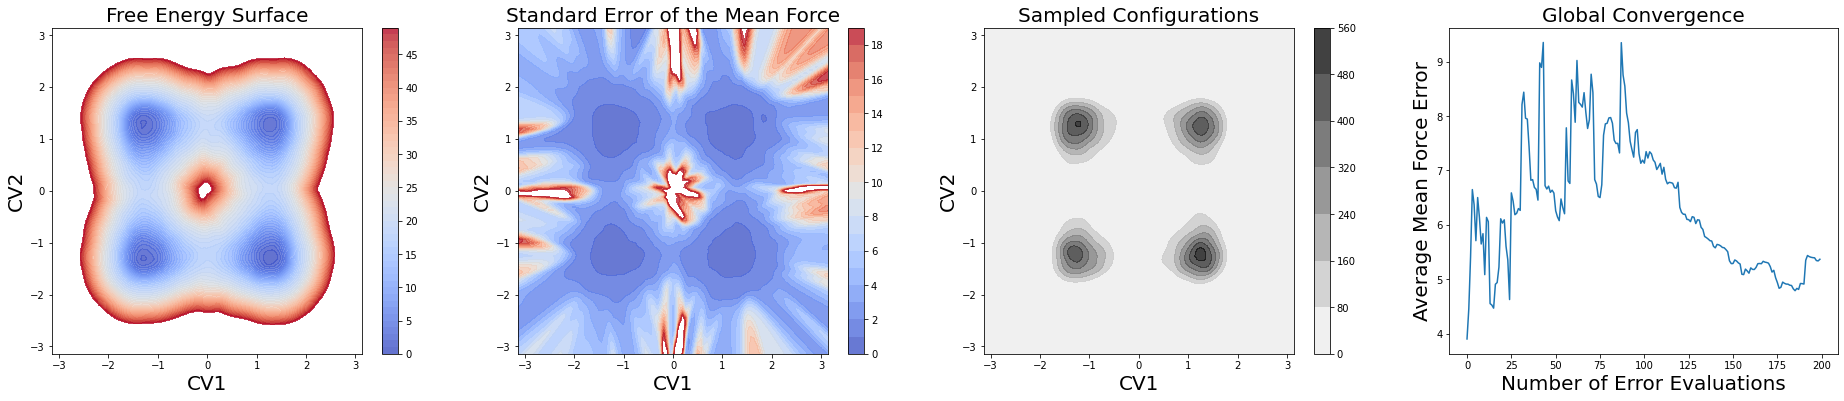

In [5]:
#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_potential")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_potential")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 100, error_pace = 200, nhills=5000)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

#Simpler integration test
[X, Y, FES2] = MFI.intg_2D(Ftot_x, Ftot_y) 

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history)